In [10]:
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime
import csv
import talos
from talos.utils import lr_normalizer
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.activations import relu, elu
from tensorflow.keras.losses import mean_squared_error
from talos.utils import hidden_layers
import math
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# df = pd.read_csv("Data\\Y2EOL_Data.csv") # read in the dataset
df = pd.read_csv("Data\\Y2EOL_Large_Dataset.csv") # read in the dataset
df = df.drop("INTRODUCTION_DATE", axis = 1)
df = df.drop("OBSOLESCENCE_LTB_DATE", axis = 1)

labels = list(df.columns)
row_index = 0

while row_index < len(df): # eliminate the rows where the obsolete date is later than the intro date
    intro_index = labels.index("INTRO_DATE (YRS SINCE 1980)")
    obsolete_index = labels.index("ACTUAL_OBSOLESCENCE_DATE (YRS SINCE 1980)")
    if df.iloc[row_index,intro_index] > df.iloc[row_index,obsolete_index]: # if the intro date is later than the obsolete date
        df = df.drop(df.index[row_index],axis=0)
    else:
        row_index += 1

df = df.drop('PART', axis = 1) # Remove the part number column
#df = df.drop('Vendor', axis = 1) # Remove the vendor column
#df = df.drop('PL Name', axis = 1) # Remove the product lines column

vendor_df = df['Vendor'] # Use the vendor column
product_df = df['PL Name'] # Use the product column

vendor_tokenizer = Tokenizer(split=" ")
product_tokenizer = Tokenizer(split=" ")

vendor_tokenizer.fit_on_texts(vendor_df) # assign an integer value to each word; more frequent word => lower value
product_tokenizer.fit_on_texts(product_df) # assign an integer value to each word; more frequent word => lower value

vendor_vocab_size = len(vendor_tokenizer.word_index) + 1
product_vocab_size = len(product_tokenizer.word_index) + 1

vendor_sequences = vendor_tokenizer.texts_to_sequences(vendor_df) # convert each word to its integer value
product_sequences = product_tokenizer.texts_to_sequences(product_df) # convert each word to its integer value

vendor_max_length = 0
for vendor in vendor_sequences:
    if len(vendor) > vendor_max_length:
        vendor_max_length = len(vendor)

print("Vendor Max Length: " + str(vendor_max_length))
vendor_sequences = pad_sequences(vendor_sequences, maxlen=vendor_max_length, padding='post')

product_max_length = 0

for product in product_sequences:
    if len(product) > product_max_length:
        product_max_length = len(product)

print("Product Max Length: " + str(product_max_length))
product_sequences = pad_sequences(product_sequences, maxlen=product_max_length, padding='post')

# EMBEDDINGS FOR VENDOR LABELS
vendor_model = Sequential()
vendor_embedding_layer = Embedding(input_dim=vendor_vocab_size,output_dim=3,input_length=vendor_max_length)
vendor_model.add(vendor_embedding_layer)
vendor_model.compile(optimizer='adam',loss='mse')

vendor_pred = vendor_model.predict(vendor_sequences)

print("Pre-Formatted Predictions: " + str(vendor_pred.shape))

vendor_formatted_pred = vendor_pred.reshape(vendor_pred.shape[0],vendor_pred.shape[1]*vendor_pred.shape[2])

print("Post-Formatted Predictions: " + str(vendor_formatted_pred.shape))

# EMBEDDINGS FOR PRODUCT LABELS
product_model = Sequential()
product_embedding_layer = Embedding(input_dim=product_vocab_size,output_dim=3,input_length=product_max_length)
product_model.add(product_embedding_layer)
product_model.compile(optimizer='adam',loss='mse')

product_pred = product_model.predict(product_sequences)

print("Pre-Formatted Predictions: " + str(product_pred.shape))

product_formatted_pred = product_pred.reshape(product_pred.shape[0],product_pred.shape[1]*product_pred.shape[2])

print("Post-Formatted Predictions: " + str(product_formatted_pred.shape))

df = df.drop('Vendor', axis = 1) # Remove the vendor column
df = df.drop('PL Name', axis = 1) # Remove the product column

for i in range(0,vendor_formatted_pred.shape[1]):
    df["VENDOR_EMBED_"+str(i+1)] = vendor_formatted_pred[:,i]

for i in range(0,product_formatted_pred.shape[1]):
    df["PRODUCT_EMBED_"+str(i+1)] = product_formatted_pred[:,i]

Vendor Max Length: 5
Product Max Length: 6
Pre-Formatted Predictions: (2399, 5, 3)
Post-Formatted Predictions: (2399, 15)
Pre-Formatted Predictions: (2399, 6, 3)
Post-Formatted Predictions: (2399, 18)


In [11]:
# split into input (X) and output (Y) variables
Y = np.array(df['ACTUAL_OBSOLESCENCE_DATE (YRS SINCE 1980)']) # Output: Obsolescence Date
Y = Y.reshape(len(Y),1)
df = df.drop('ACTUAL_OBSOLESCENCE_DATE (YRS SINCE 1980)', axis = 1) # Remove the obsolescence date column

lifecycle = pd.get_dummies(df['LIFECYCLE_STATUS'])

X = df.drop('LIFECYCLE_STATUS', axis=1)
X['LTB'] = lifecycle['LTB']
X['Obsolete'] = lifecycle['Obsolete']

labels = list(X.columns)
X = np.array(X)

scaler = StandardScaler() # the scaler object
X = scaler.fit_transform(X) # fit and transform the data
# X = talos.utils.rescale_meanzero(X)

X = X.astype('float32')
Y = Y.astype('float32')

print("Y: " + str(Y.shape))
print("X: " + str(X.shape))

Y: (2399, 1)
X: (2399, 38)


In [12]:
# split dataset into train, validation, test
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state = 42)

def keras_model(x_train,y_train,x_val,y_val,params):

    # create model
    model = Sequential()

    # input layer and 1st hidden layer
    model.add(Dense(units=params['first_hidden_layer'], input_dim=train_X.shape[1], 
                    activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer
    model.add(Dense(units=params['second_hidden_layer'], activation=params['activation'], 
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # hidden layer 
    model.add(Dense(units=params['third_hidden_layer'], activation=params['activation'],
                    kernel_initializer='normal'))

    # dropout layer
    model.add(Dropout(params['dropout']))

    # output layer
    model.add(Dense(units=1, activation=params['last_activation'], 
                    kernel_initializer='normal'))

    # compile model
    model.compile(loss='mean_squared_error',
                  optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
                  metrics=keras.metrics.mean_squared_error)

    # train model
    history = model.fit(x=x_train,
                        y=y_train, 
                        validation_data=(x_val,y_val),
                        batch_size=params['batch_size'],
                        epochs=params['epochs'],
                        verbose=0)

    return history,model

# set the parameter space

p = {'lr': [0.1, 0.3, 0.5], # learning rate [0.1,0.3,0.5]
     'first_hidden_layer':[8, 16, 32, 64, 128], # neurons in first layer
     'second_hidden_layer':[8, 16, 32, 64], # neurons in second layer
     'third_hidden_layer':[8, 16, 32, 64], # neurons in third layer [8,16,32,64]
     'batch_size': (2, 30, 10), # batch size [5,10,50]
     'epochs': [150], # number of epochs
     'dropout': [0.3, 0.5], # percentage of input that is ignored
     'optimizer': [Adam], # methods of gradient descent
     'losses': [mean_squared_error], # cost function
     'activation':[relu], # maps the layer's input to output
     'last_activation': [None],
     'weight_regulizer':[None],
     'emb_output_dims': [None]}

# run the experiment
scan_object = talos.Scan(x=train_X,
                         y=train_Y,
                         val_split = 0.25,
                         model=keras_model,
                         params=p,
                         experiment_name='Talos_Optimization',
                         fraction_limit=.01)

100%|██████████| 48/48 [20:21<00:00, 25.45s/it]


<class 'numpy.ndarray'>
Best params: [[32 150 4 '08/31/21-144153'
  <function mean_squared_error at 0x00000208F527E040> 7.194664001464844
  <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> None 0.3 150
  None 128 <function relu at 0x00000208FFDBD280> 7.194664001464844 0.5
  45.246782541275024 '08/31/21-144238' 17.490806579589844 64 None 0]]


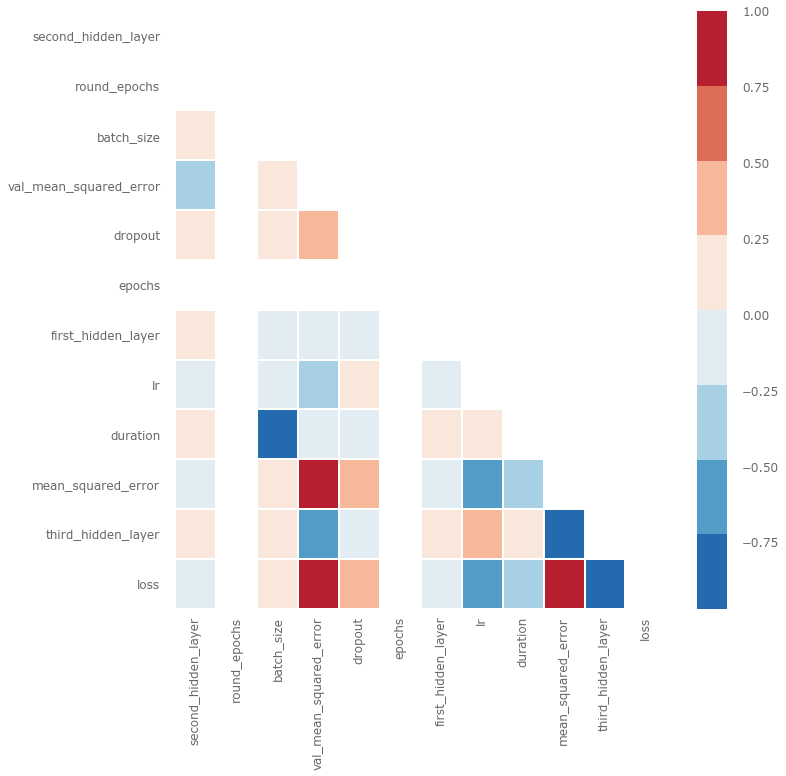

In [13]:
%matplotlib inline
# show the best parameters
analyze_object = talos.Analyze(scan_object)
best_params = analyze_object.best_params(metric='loss', exclude=['acc', 'loss', 'val_acc'], n=1, ascending=True)
print(type(best_params))
print('Best params: ' + str(best_params))

# heatmap correlation (show the correlation between the parameters)
analyze_object.plot_corr('loss', ['acc', 'val_loss', 'val_acc'])

Error Standard Deviation: 2.559854
Error Mean: -0.5649017
9.58% of the predictions fall within 0.5 years of the ground truths.


Text(0.5, 1.0, 'Error Distribution')

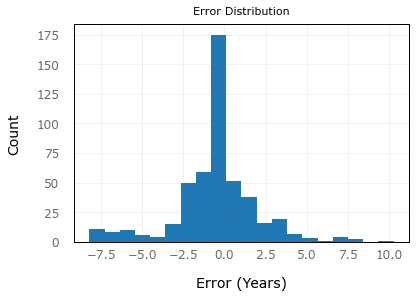

In [14]:
best_model = scan_object.best_model(metric='loss', asc=True) # we want to minimize the loss

predictions = best_model.predict(test_X)

# calculate errors and show histogram
errors = predictions - test_Y # calculate the errors
std = errors.std()
print("Error Standard Deviation: " + str(std))
print("Error Mean: " + str(np.mean(errors)))

threshold = 0.5
count = 0
for error in errors:
    if abs(error) <= threshold:
        count += 1

thres_percentage = count / len(errors) * 100.0
print(str(round(thres_percentage,2)) + "%" + " of the predictions fall within " + str(threshold) + " years of the ground truths.")

plt.hist(errors,bins=20)
plt.xlabel('Error (Years)')
plt.ylabel('Count')
plt.title('Error Distribution')

In [15]:
# plot the loss over time for the best model

filename = 'Talos_Optimization\\experiment_3.csv' # UPDATE WITH THE PROPER EXPERIMENT NAME
r = talos.Reporting(filename)

df = pd.read_csv(filename)
df = np.array(df)

best_index = 0

for row_index in range(0,len(df)):
    df_val = df[row_index][1]
    lowest_loss = r.low(metric='loss')
    
    if math.isclose(df_val, lowest_loss, rel_tol=1e-09, abs_tol=0.0):
        best_index = row_index

history_loss = scan_object.round_history[best_index]['loss']

plt.plot(history_loss, color = 'red', label ='loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Over Time')

IndexError: list index out of range

In [ ]:
def floatHourToTime(fh):
    hours, hourSeconds = divmod(fh, 1)
    minutes, seconds = divmod(hourSeconds * 60, 1)
    return (
        int(hours),
        int(minutes),
        int(seconds * 60),
    )

def floatsToDates(values):

    values += 80
    values *= 365.25
    values
    formatted_values = np.copy(values).astype('str')

    for i in range(0,len(values)):
        excel_date = values[i]
        dt = datetime.fromordinal(datetime(1900, 1, 1).toordinal() + int(excel_date) - 2)
        hour, minute, second = floatHourToTime(excel_date % 1)
        dt = dt.replace(hour=hour, minute=minute, second=second)
        dt = str(dt).split(" ")
        del dt[-1]
        formatted_values[i] = dt[0]

    return formatted_values

copy_predictions = np.copy(predictions)
copy_test_Y = np.copy(test_Y)

formatted_predictions = floatsToDates(predictions)
formatted_actuals = floatsToDates(test_Y)

labels.append("PREDICTION")
labels.append("GROUND_TRUTH")

test_X = test_X.tolist()
formatted_predictions = formatted_predictions.tolist()
formatted_actuals = formatted_actuals.tolist()

for row_index in range(0,len(test_X)): #for each row, append the data value
    test_X[row_index].append(formatted_predictions[row_index])
    test_X[row_index].append(formatted_actuals[row_index])

# name of csv file
filename = "Data\\Y2EOL_Predictions_DL.csv"

# writing to csv file
with open(filename, 'w') as csvfile: 
    # creating a csv writer object
    csvwriter = csv.writer(csvfile,lineterminator='\n')

    # writing the fields 
    csvwriter.writerow(labels) 

    # writing the data rows 
    csvwriter.writerows(test_X)

Text(0.5, 1.0, 'Actual and Predicted Values')

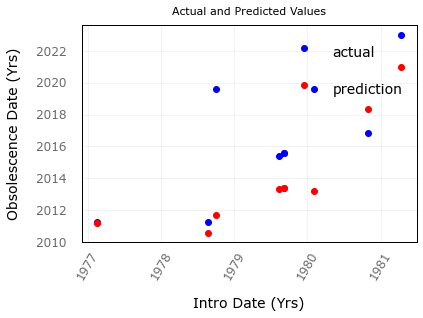

In [ ]:
'''
INTRODUCTION DATE IS THE X COORDINATE, THE Y COORDINATE IS THE PREDICTION & ACTUAL
Y COORDINATE CAN BE ANY FORMAT AS LONG AS IT'S CONSISTENT
'''

def year_format(a):
    a += 1980
    return a

test_X = np.array(test_X)
test_X = test_X[0:9,:]
intro_dates = test_X[:,labels.index('INTRO_DATE (YRS SINCE 1980)')]

intro_dates = intro_dates.astype(float)
intro_dates = year_format(intro_dates)
test_Y = year_format(copy_test_Y)
predictions = year_format(copy_predictions)

# Plot the actual values
plt.plot(intro_dates, test_Y[0:9], 'ro', label = 'actual', color = 'blue')
# Plot the predicted values
plt.plot(intro_dates, predictions[0:9], 'ro', label = 'prediction', color = 'red')
plt.xticks(rotation = '60')
plt.legend()
# Graph labels
plt.xlabel('Intro Date (Yrs)')
plt.ylabel('Obsolescence Date (Yrs)')
plt.title('Actual and Predicted Values')